In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

## Load Your Dataset
Replace the path below with the actual location of your CSV or Parquet file.

In [3]:
final_demo = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt')
# A list revealing which clients were part of the grand experiment
df_final_experiment_clients = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_experiment_clients.txt')
# A detailed trace of client interactions online, divided into two parts: 
# pt_1 and pt_2. It's recommended to merge these two files prior to a comprehensive data analysis.
df_final_web_data_pt_1 = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_1.txt')
df_final_web_data_pt_2 = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_2.txt')
# pt1 and pt2 are combined
combined = pd.concat([df_final_web_data_pt_1,df_final_web_data_pt_1], ignore_index=True)
# Example: Read CSV
# combined = pd.read_csv("combined.csv")

# Preview data
combined.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [31]:
final_demo.head()
# Who are the primary clients using this online process? - Test group
final_demo_clean = final_demo.copy()
final_demo_clean['gender'] = final_demo_clean['gendr'].replace(['U', 'X', 'NaN'], 'U')

# final_demo[['client_id', 'clnt_age', 'gendr']] 

median_age = final_demo_clean['clnt_age'].median()
median_tenure_year = final_demo_clean['clnt_tenure_yr'].median()
median_tenure_month = final_demo_clean['clnt_tenure_mnth'].median()
final_demo_clean['tenure_years'] = final_demo_clean['clnt_tenure_yr'].apply(lambda x: 'new-standing' if x<median_tenure_year else 'long-standing')
final_demo_clean['tenure_month'] = final_demo_clean['clnt_tenure_mnth'].apply(lambda x: 'new-standing' if x<median_tenure_month else 'long-standing')
final_demo_clean['age_group'] = final_demo_clean['clnt_age'].apply(lambda x: 'younger' if x<median_age else 'older')

clients_age_tenure = final_demo_clean[['client_id', 'gender', 'age_group', 'tenure_years', 'tenure_month']]
test_group = df_final_experiment_clients[df_final_experiment_clients['Variation'] == 'Test']
merged_clients = pd.merge(clients_age_tenure, test_group, on='client_id', how='inner')
merged_clients.head()

,client_id,gender,age_group,tenure_years,tenure_month,Variation
0,836976,U,older,new-standing,new-standing,Test
1,1439522,U,younger,new-standing,new-standing,Test
2,1562045,M,older,long-standing,long-standing,Test
3,388801,M,older,long-standing,long-standing,Test
4,8198645,F,older,long-standing,long-standing,Test


## Preprocessing and Feature Engineering

In [4]:

# Convert date_time to datetime format
combined['date_time'] = pd.to_datetime(combined['date_time'])

# Sort for step sequencing
combined = combined.sort_values(by=['visitor_id', 'visit_id', 'date_time'])

# Calculate time spent on each step
combined['next_time'] = combined.groupby(['visitor_id', 'visit_id'])['date_time'].shift(-1)
combined['time_spent'] = (combined['next_time'] - combined['date_time']).dt.total_seconds()

# Map process_step to an ordered number
step_order = {step: i+1 for i, step in enumerate(combined['process_step'].unique())}
combined['step_number'] = combined['process_step'].map(step_order)
combined['next_step'] = combined.groupby(['visitor_id', 'visit_id'])['step_number'].shift(-1)
combined['step_change'] = combined['next_step'] - combined['step_number']
combined['backward_flag'] = combined['step_change'] < 0

combined.head()


,client_id,visitor_id,visit_id,process_step,date_time,next_time,time_spent,step_number,next_step,step_change,backward_flag
101048,6265388,100019786_4272121951,703380671_89376183829_330646,start,2017-04-15 15:13:33,2017-04-15 15:13:33,0.0,1,1.0,0.0,False
444189,6265388,100019786_4272121951,703380671_89376183829_330646,start,2017-04-15 15:13:33,2017-04-15 15:13:46,13.0,1,2.0,1.0,False
101047,6265388,100019786_4272121951,703380671_89376183829_330646,step_1,2017-04-15 15:13:46,2017-04-15 15:13:46,0.0,2,2.0,0.0,False
444188,6265388,100019786_4272121951,703380671_89376183829_330646,step_1,2017-04-15 15:13:46,2017-04-15 15:14:21,35.0,2,3.0,1.0,False
101046,6265388,100019786_4272121951,703380671_89376183829_330646,step_2,2017-04-15 15:14:21,2017-04-15 15:14:21,0.0,3,3.0,0.0,False


## Visualization: Average Time per Step

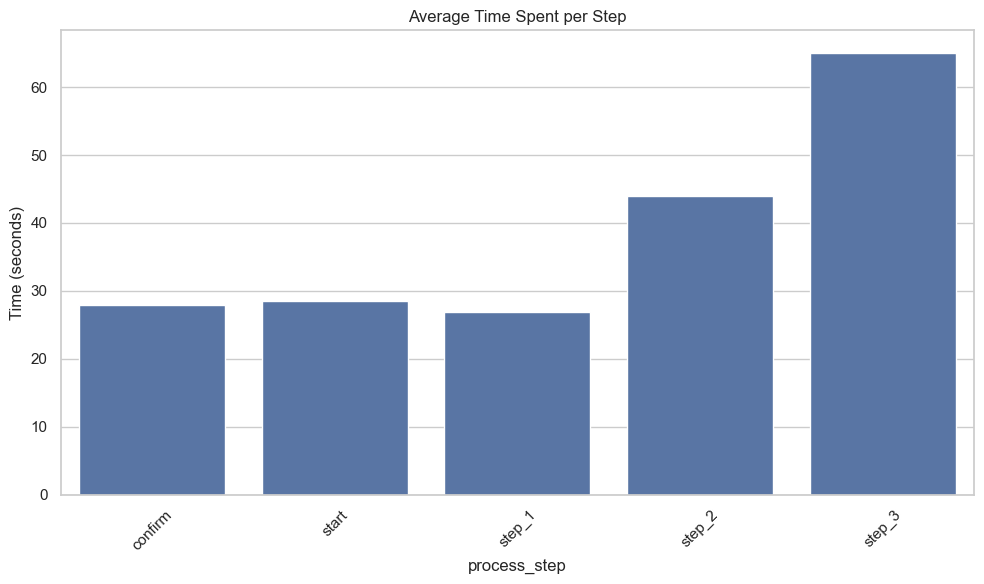

In [5]:
#How much time do users spend on each step on average? Overview

avg_time = combined.groupby('process_step')['time_spent'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_time, x='process_step', y='time_spent')
plt.title('Average Time Spent per Step')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Visualization: Error Rate (Backward Navigation) per Step

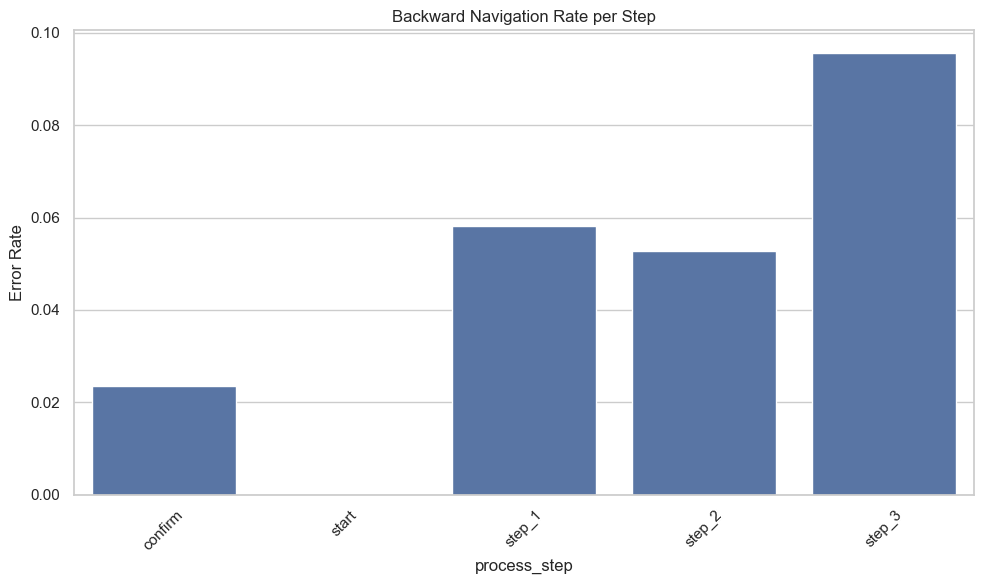

In [6]:
#How often do users go back to a previous step? Overview

error_rate = combined.groupby('process_step')['backward_flag'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=error_rate, x='process_step', y='backward_flag')
plt.title('Backward Navigation Rate per Step')
plt.ylabel('Error Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


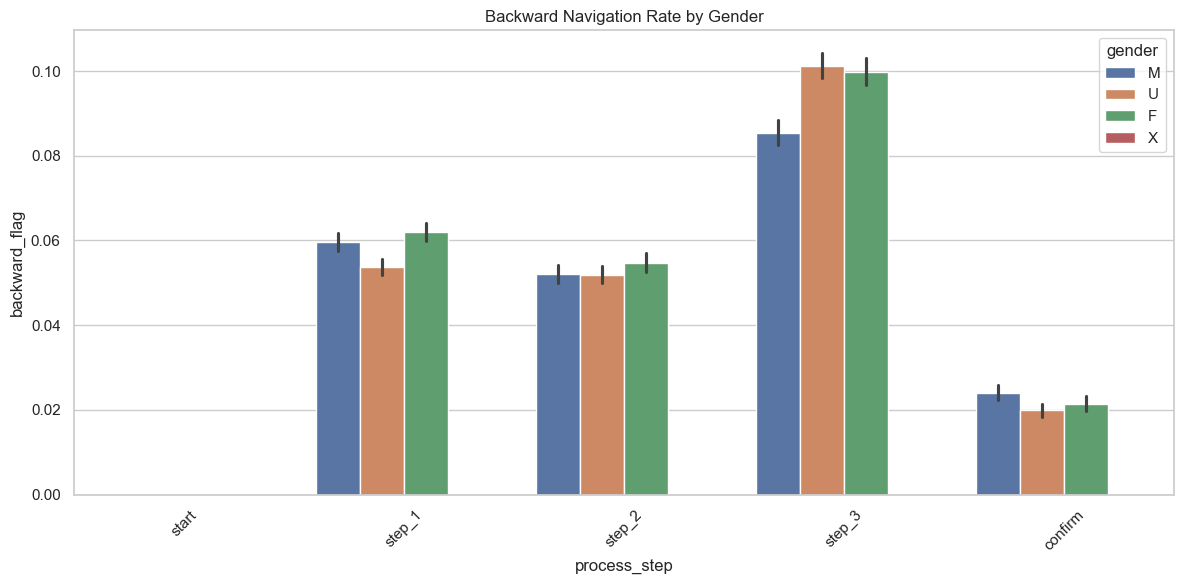

In [20]:
# Backward Navigation Rate per Step by Gender

plt.figure(figsize=(12, 6))
sns.barplot(data=combined, x='process_step', y='backward_flag', hue='gender')
plt.title('Backward Navigation Rate by Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

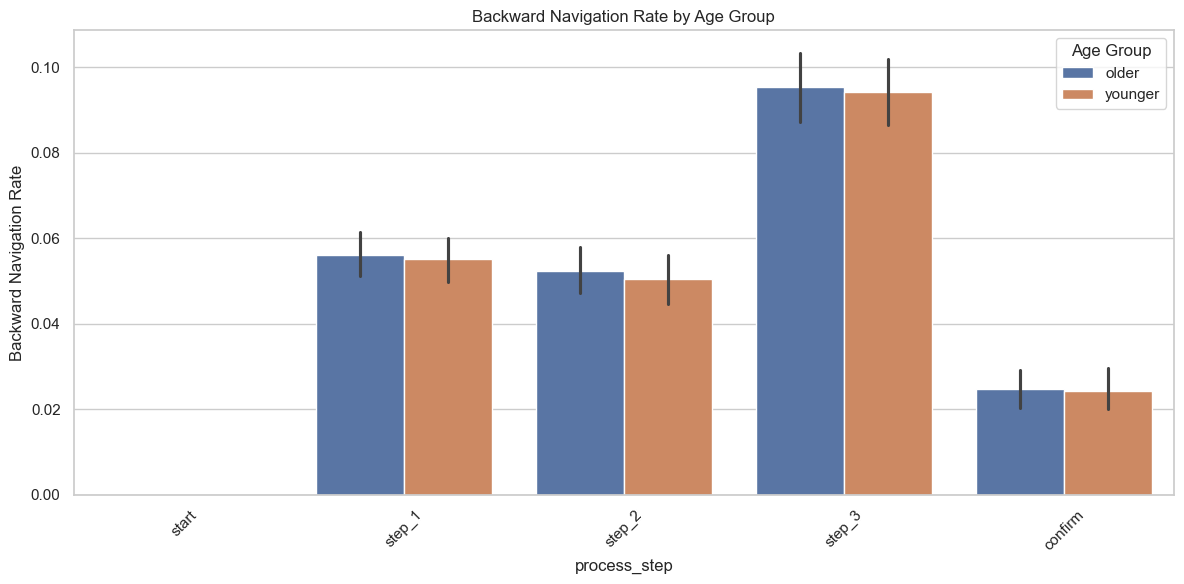

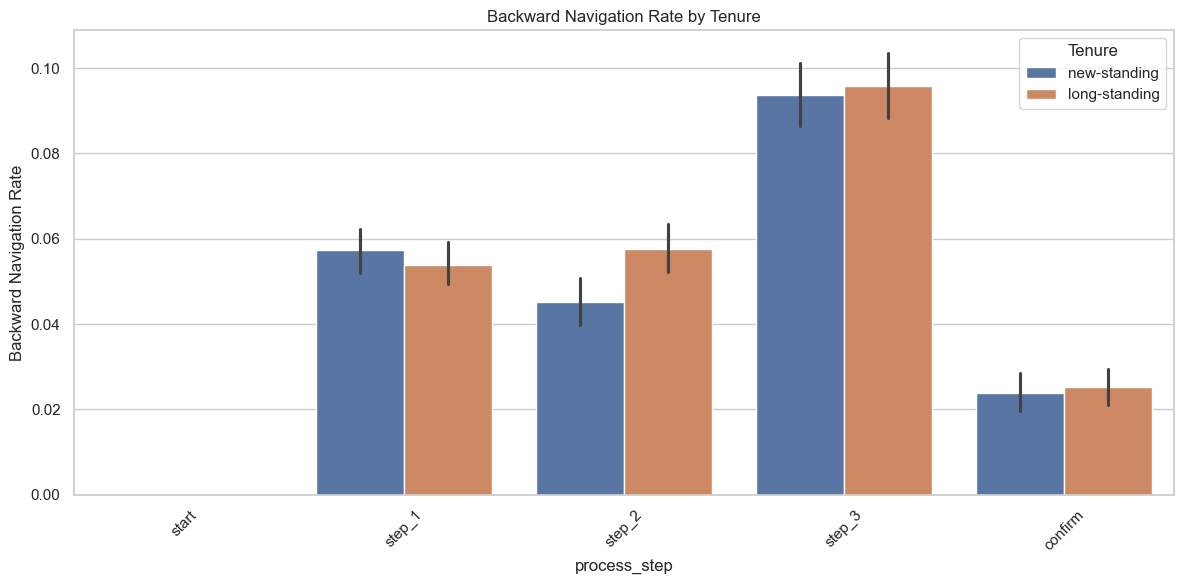

In [37]:
# 1. Backward Navigation Rate by Age Group (Younger vs Older)

plt.figure(figsize=(12, 6))
sns.barplot(data=combined, x='process_step', y='backward_flag', hue='age_group')
plt.title('Backward Navigation Rate by Age Group')
plt.ylabel('Backward Navigation Rate')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

# 2. Backward Navigation Rate by Tenure (New-standing vs Long-standing)
plt.figure(figsize=(12, 6))
sns.barplot(data=combined, x='process_step', y='backward_flag', hue='tenure_years')
plt.title('Backward Navigation Rate by Tenure')
plt.ylabel('Backward Navigation Rate')
plt.xticks(rotation=45)
plt.legend(title='Tenure')
plt.tight_layout()
plt.show()

## Visualization: Completion Funnel

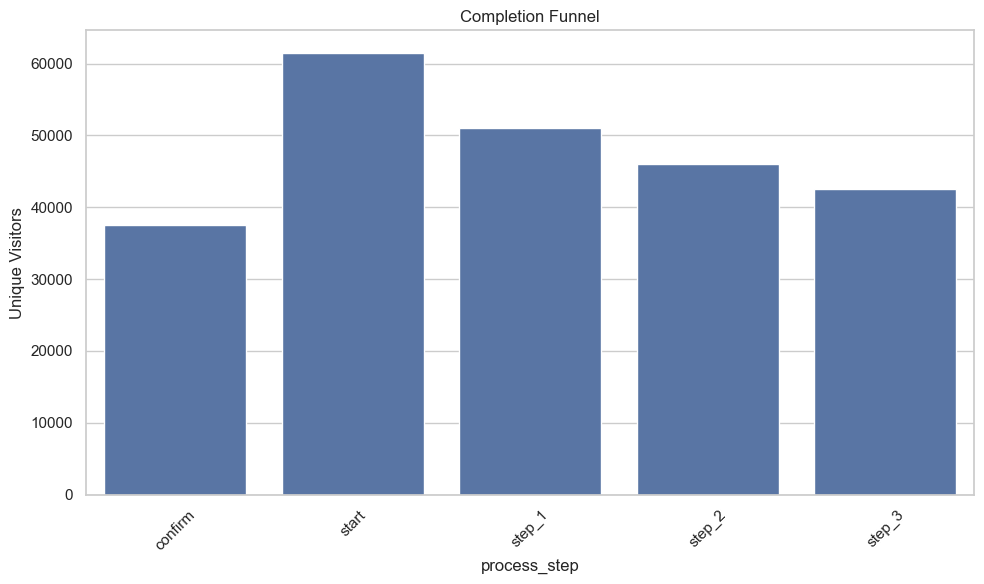

In [7]:
#What proportion of users reach the final 'confirm' step? Overview

funnel = combined.groupby('process_step')['visitor_id'].nunique().reset_index()
funnel = funnel.sort_values(by='process_step')

plt.figure(figsize=(10, 6))
sns.barplot(data=funnel, x='process_step', y='visitor_id')
plt.title('Completion Funnel')
plt.ylabel('Unique Visitors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


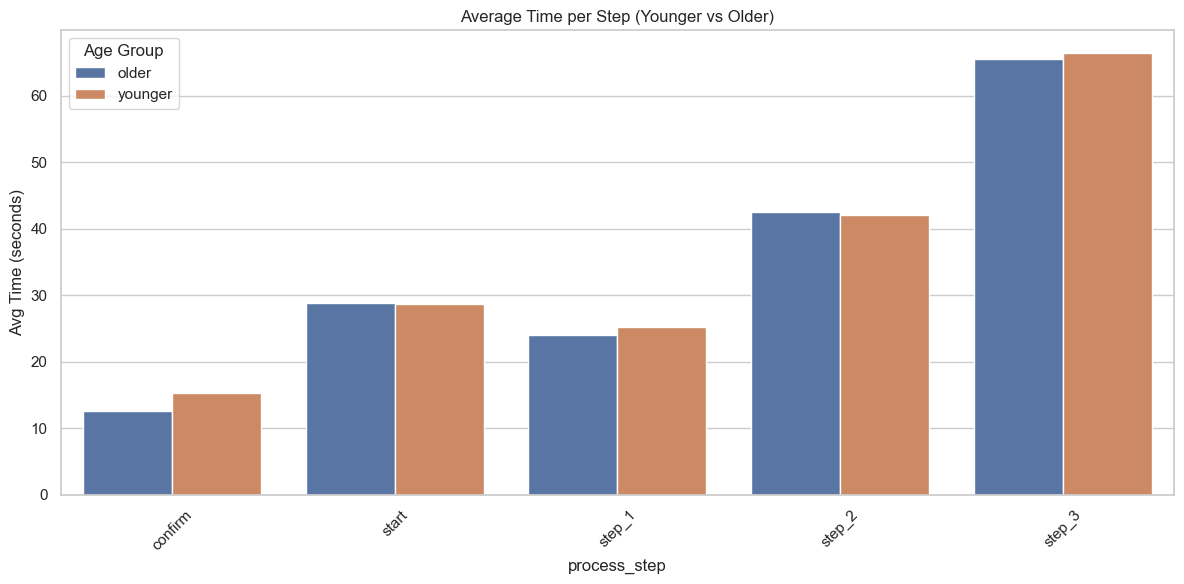

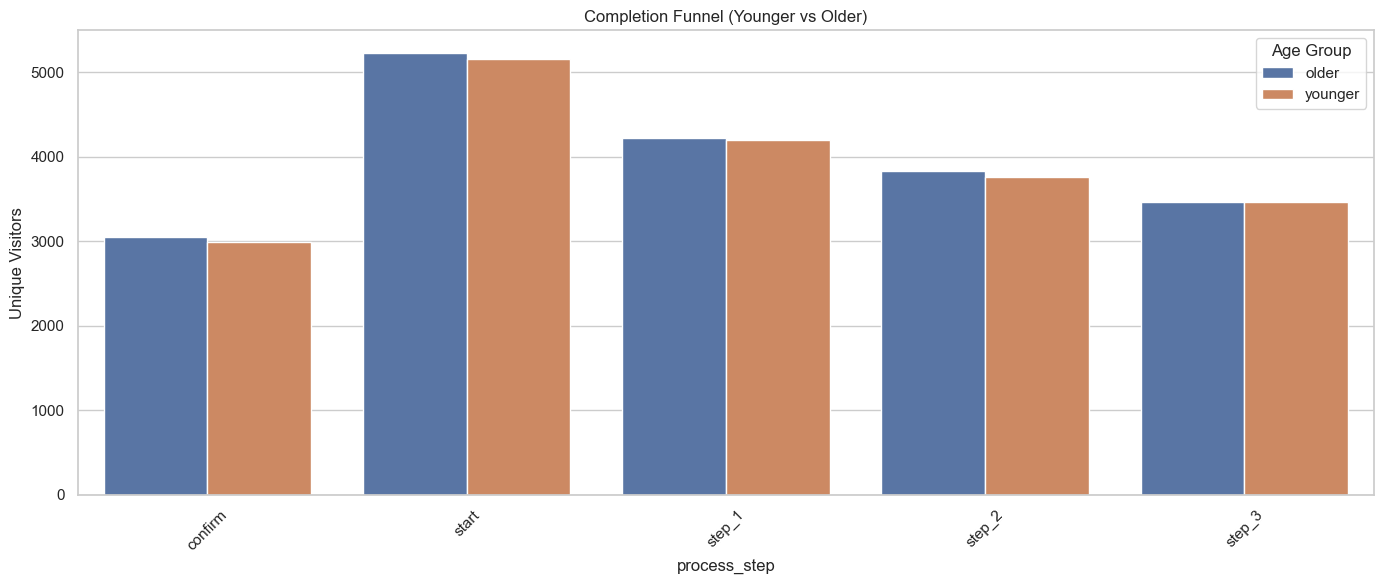

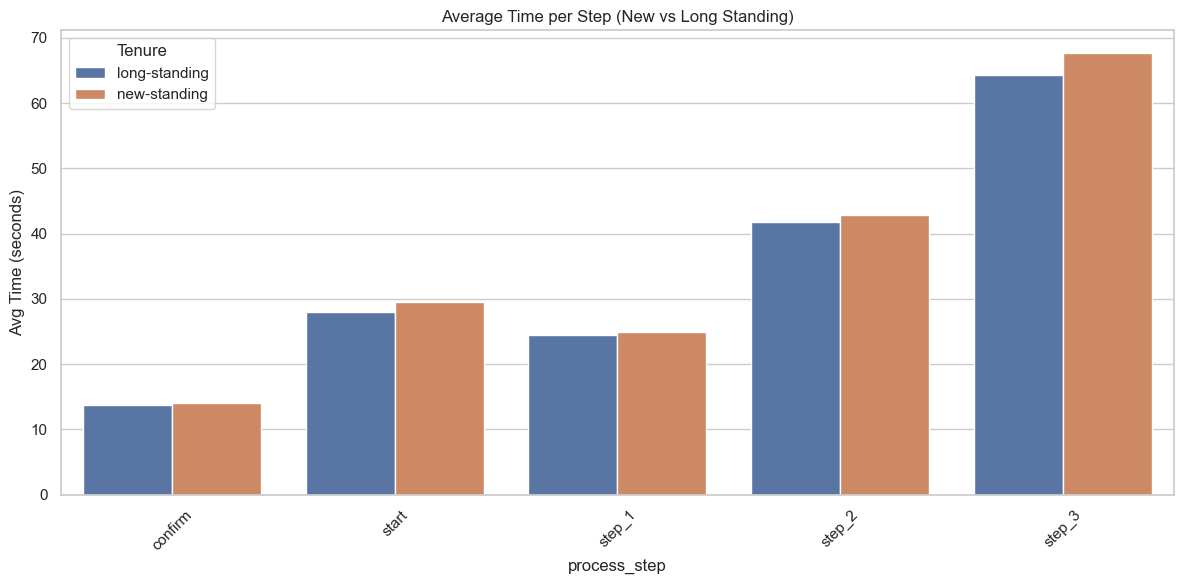

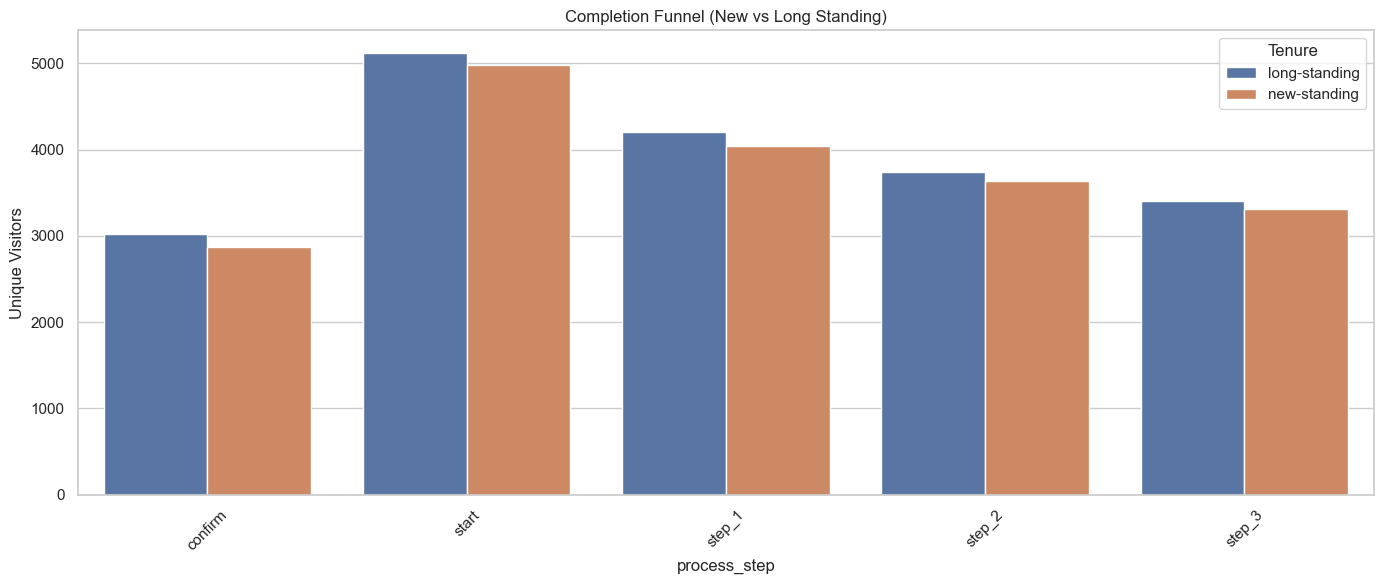

In [36]:
# --- Make sure combined has the median-based columns from final_demo_clean ---
# If combined already contains them, just use them; if not, create them:
combined['age_group'] = final_demo_clean['clnt_age'].apply(lambda x: 'younger' if x < median_age else 'older')
combined['tenure_years'] = final_demo_clean['clnt_tenure_yr'].apply(lambda x: 'new-standing' if x < median_tenure_year else 'long-standing')

# 1. Average Time per Step by Age (Younger vs Older)
plt.figure(figsize=(12, 6))
avg_time_age = combined.groupby(['process_step', 'age_group'])['time_spent'].mean().reset_index()
sns.barplot(data=avg_time_age, x='process_step', y='time_spent', hue='age_group')
plt.title('Average Time per Step (Younger vs Older)')
plt.ylabel('Avg Time (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

# 2. Completion Funnel by Age
plt.figure(figsize=(14, 6))
funnel_age = combined.groupby(['process_step', 'age_group'])['visitor_id'].nunique().reset_index()
sns.barplot(data=funnel_age, x='process_step', y='visitor_id', hue='age_group')
plt.title('Completion Funnel (Younger vs Older)')
plt.ylabel('Unique Visitors')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

# 3. Average Time per Step by Tenure (New vs Long Standing)
plt.figure(figsize=(12, 6))
avg_time_tenure = combined.groupby(['process_step', 'tenure_years'])['time_spent'].mean().reset_index()
sns.barplot(data=avg_time_tenure, x='process_step', y='time_spent', hue='tenure_years')
plt.title('Average Time per Step (New vs Long Standing)')
plt.ylabel('Avg Time (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Tenure')
plt.tight_layout()
plt.show()

# 4. Completion Funnel by Tenure
plt.figure(figsize=(14, 6))
funnel_tenure = combined.groupby(['process_step', 'tenure_years'])['visitor_id'].nunique().reset_index()
sns.barplot(data=funnel_tenure, x='process_step', y='visitor_id', hue='tenure_years')
plt.title('Completion Funnel (New vs Long Standing)')
plt.ylabel('Unique Visitors')
plt.xticks(rotation=45)
plt.legend(title='Tenure')
plt.tight_layout()
plt.show()

## Hypothesis Test: Step 1 vs Step 2 Time Comparison

In [8]:
# Ensure datetime
combined['date_time'] = pd.to_datetime(combined['date_time'])

# Normalize process_step strings
combined['process_step'] = combined['process_step'].astype(str).str.strip().str.lower()

# Sort by client, visit, datetime
combined = combined.sort_values(['client_id', 'visit_id', 'date_time'])

# Compute time spent per step as difference to next step within same visit
combined['time_spent'] = (
    combined.groupby(['client_id', 'visit_id'])['date_time'].shift(-1)
    - combined['date_time']
).dt.total_seconds()

# Compute median time per process step
medians = combined.groupby('process_step')['time_spent'].median()

# Fill NaNs (last steps and single-step visits) with median per step
combined['time_spent'] = combined['time_spent'].fillna(combined['process_step'].map(medians))

# Identify the steps to compare
unique_steps = combined['process_step'].unique()
if 'step 1' in unique_steps and 'step 2' in unique_steps:
    step_a_name = 'step 1'
    step_b_name = 'step 2'
else:
    # fallback: pick first two unique steps
    step_a_name, step_b_name = unique_steps[:2]
    print(f"Using first two steps for t-test: '{step_a_name}' vs '{step_b_name}'")

# Prepare step-wise series for t-test
step_a_times = combined[combined['process_step'] == step_a_name]['time_spent'].dropna()
step_b_times = combined[combined['process_step'] == step_b_name]['time_spent'].dropna()

# Check counts and variance
print(f"{step_a_name}: count={len(step_a_times)}, variance={step_a_times.var()}")
print(f"{step_b_name}: count={len(step_b_times)}, variance={step_b_times.var()}")

# Run t-test if valid
if len(step_a_times) < 2 or len(step_b_times) < 2:
    print("Cannot run t-test: one group has fewer than 2 observations.")
elif step_a_times.var() == 0 or step_b_times.var() == 0:
    print("Cannot run t-test: one group has zero variance.")
else:
    t_stat, p_val = ttest_ind(step_a_times, step_b_times, equal_var=False)
    print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

Using first two steps for t-test: 'start' vs 'step_1'
start: count=217820, variance=22362.9733576463
step_1: count=146864, variance=9088.497676783993
T-statistic: 0.79, p-value: 0.4302


Summary statistics per step:
               count       mean  median         std
process_step                                       
confirm        90806  14.482887     0.0  119.670502
start         217820  25.757254     0.0  149.542547
step_1        146864  25.437282     0.0   95.333613
step_2        123536  42.791089     0.0  102.186741
step_3        107256  62.145624     0.0  161.871686


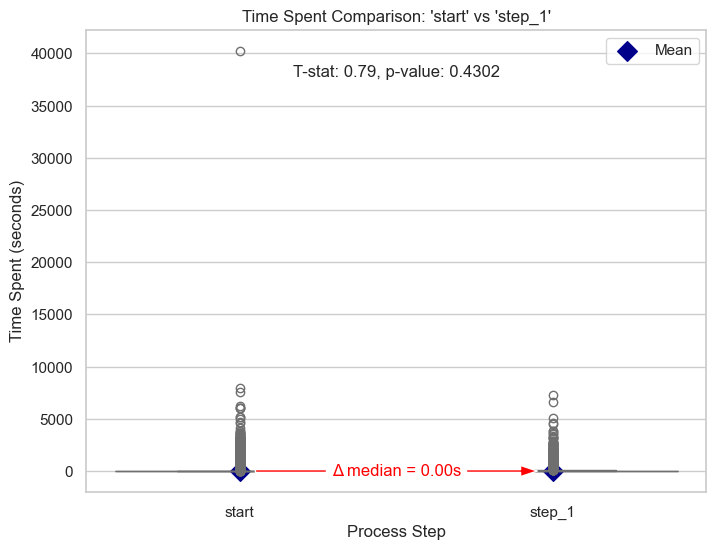

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
summary = combined.groupby('process_step')['time_spent'].agg(['count', 'mean', 'median', 'std'])
print("Summary statistics per step:")
print(summary)

# Boxplot
plt.figure(figsize=(8,6))
ax = sns.boxplot(
    x='process_step', y='time_spent', 
    data=combined[combined['process_step'].isin([step_a_name, step_b_name])],
    palette=["skyblue", "lightgreen"]
)

plt.title(f"Time Spent Comparison: '{step_a_name}' vs '{step_b_name}'")

# Overlay mean values
means = combined.groupby('process_step')['time_spent'].mean()
for i, step in enumerate([step_a_name, step_b_name]):
    plt.scatter(i, means[step], color='darkblue', s=100, marker='D', label='Mean' if i == 0 else "")

# Annotate t-test result
t_test_valid = len(step_a_times) >= 2 and len(step_b_times) >= 2 and step_a_times.var() != 0 and step_b_times.var() != 0
if t_test_valid:
    plt.text(0.5, max(combined['time_spent']) * 0.95,
             f"T-stat: {t_stat:.2f}, p-value: {p_val:.4f}",
             ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
else:
    plt.text(0.5, max(combined['time_spent']) * 0.95,
             "T-test not valid (insufficient data or zero variance)",
             ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Highlight median difference
med_a = step_a_times.median()
med_b = step_b_times.median()
plt.annotate('', xy=(1, med_b), xytext=(0, med_a),
             arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8))
plt.text(0.5, (med_a + med_b)/2, f"Δ median = {abs(med_b - med_a):.2f}s", 
         color='red', ha='center', va='center', fontsize=12, backgroundcolor='white')

# Automatically indicate which step is longer if t-test is significant
if t_test_valid and p_val < 0.05:
    longer_step = step_a_name if med_a > med_b else step_b_name
    plt.text(0.5, max(combined['time_spent']) * 0.9,
             f"'{longer_step}' takes significantly longer",
             ha='center', va='center', fontsize=12, color='darkred', weight='bold',
             bbox=dict(facecolor='white', alpha=0.7))

# Add legend for mean marker
plt.legend(loc='upper right')

plt.ylabel("Time Spent (seconds)")
plt.xlabel("Process Step")
plt.show()

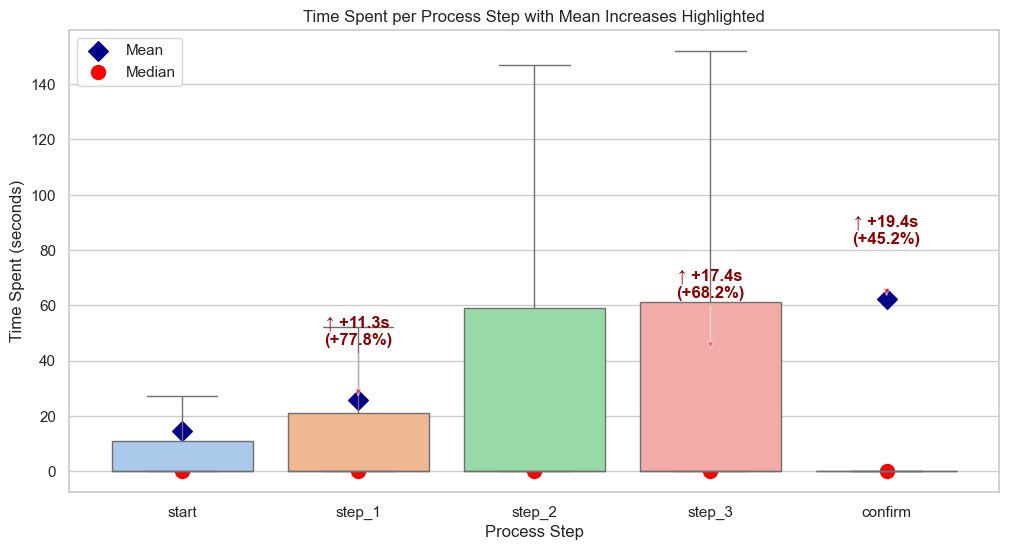

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

steps_to_plot = ['confirm', 'start', 'step_1', 'step_2', 'step_3']

plt.figure(figsize=(12,6))

# Boxplot
ax = sns.boxplot(
    x='process_step', y='time_spent',
    data=combined[combined['process_step'].isin(steps_to_plot)],
    palette="pastel",
    showfliers=False
)

# Overlay mean and median
means = combined.groupby('process_step')['time_spent'].mean()
medians = combined.groupby('process_step')['time_spent'].median()

for i, step in enumerate(steps_to_plot):
    plt.scatter(i, means[step], color='darkblue', s=100, marker='D', label='Mean' if i == 0 else "")
    plt.scatter(i, medians[step], color='red', s=100, marker='o', label='Median' if i == 0 else "")

# Annotate increases and percentage increases
for i in range(1, len(steps_to_plot)):
    prev_step = steps_to_plot[i-1]
    curr_step = steps_to_plot[i]
    mean_diff = means[curr_step] - means[prev_step]
    if mean_diff > 0:
        pct_increase = (mean_diff / means[prev_step]) * 100
        plt.annotate(
            f"↑ +{mean_diff:.1f}s\n(+{pct_increase:.1f}%)", 
            xy=(i, means[curr_step]), 
            xytext=(i, means[curr_step] + 20),
            ha='center', color='darkred', weight='bold',
            arrowprops=dict(facecolor='red', arrowstyle='-|>', alpha=0.5)
        )

# Labels, title, legend
plt.title("Time Spent per Process Step with Mean Increases Highlighted")
plt.ylabel("Time Spent (seconds)")
plt.xlabel("Process Step")
plt.legend(loc='upper left')

plt.show()

In [17]:
import pandas as pd

# Compute mean time per step
mean_times = combined.groupby('process_step')['time_spent'].mean().reindex(steps_to_plot)

# Create table of differences
increase_table = pd.DataFrame({
    'Step': steps_to_plot[1:],  # from second step onward
    'Mean_Time': mean_times[1:].values,
    'Mean_Time_Prev': mean_times[:-1].values
})

increase_table['Absolute_Increase'] = increase_table['Mean_Time'] - increase_table['Mean_Time_Prev']
increase_table['Percent_Increase'] = (increase_table['Absolute_Increase'] / increase_table['Mean_Time_Prev']) * 100

# Optional: round for clarity
increase_table = increase_table.round({
    'Mean_Time': 2,
    'Mean_Time_Prev': 2,
    'Absolute_Increase': 2,
    'Percent_Increase': 1
})

print(increase_table)

     Step  Mean_Time  Mean_Time_Prev  Absolute_Increase  Percent_Increase
0   start      25.76           14.48              11.27              77.8
1  step_1      25.44           25.76              -0.32              -1.2
2  step_2      42.79           25.44              17.35              68.2
3  step_3      62.15           42.79              19.35              45.2


Observations

Median = 0 for all steps

Most users spend 0 seconds on a step, meaning they either skip it or it is instantaneous for the majority.

Median is not representative here; we need to focus on mean and variance.

Means

start ≈ 25.76 s, step_1 ≈ 25.44 s → roughly the same average time.

step_2 ≈ 42.79 s, step_3 ≈ 62.15 s → later steps take more time on average.

confirm is shortest, ≈ 14.48 s.

Standard deviation (spread)

Very high compared to the mean for all steps (especially step_3 = 161.87 s).

This indicates high variability, likely due to some users spending a very long time while most spend little.

Skewed distributions

The combination of median = 0 and high mean/std suggests a right-skewed distribution: many quick users, a few slow users.

Conclusions

Early steps (start and step_1)

Average times are similar.

Likely no major bottleneck at these steps.

Later steps (step_2, step_3)

Time spent increases progressively.

step_3 shows largest mean and variance, which might indicate a bottleneck or complexity in the process.

Confirm step

Fastest step with small mean, though high relative variability (some users take much longer than most).

Implications for analysis

Use mean or visualization (boxplot/violin), not median, because most medians are zero.

Outliers heavily influence the mean. Consider percentiles (e.g., 90th) to understand extreme cases.

Further statistical tests (like t-tests) between steps are only meaningful if comparing users who actually spend time, not all zeros.

Bottom line:

Most users spend almost no time on most steps (median = 0).

Later steps (step_2 and step_3) are significantly longer and more variable, suggesting complexity or friction in the process.

Early steps (start, step_1) are roughly equivalent in mean time; no significant bottleneck there.

Outliers drive variability, so focus on distribution visualizations and percentile-based analysis for actionable insights.

In [46]:
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [51]:
# Compute backward navigation rate per process_step and Variation
step_rates = combined.groupby(['process_step','Variation'])['backward_flag'].agg(['sum','count']).reset_index()
step_rates.rename(columns={'sum':'backward_count','count':'total'}, inplace=True)
step_rates['rate'] = step_rates['backward_count'] / step_rates['total']

# Display rates per step
print(step_rates[['process_step','Variation','backward_count','total','rate']])

# Z-test per step (one-tailed: test > control)
print("\nZ-tests per step (H0: rate_test <= rate_control, H1: rate_test > rate_control)")
for step in step_rates['process_step'].unique():
    subset = step_rates[step_rates['process_step']==step].set_index('Variation')
    if 'test' in subset.index and 'control' in subset.index:
        count = subset.loc[['test','control'],'backward_count'].values
        nobs = subset.loc[['test','control'],'total'].values
        stat, pval = proportions_ztest(count=count, nobs=nobs, alternative='larger')
        print(f"{step}: Z={stat:.3f}, p={pval:.4f}")

  process_step Variation  backward_count  total      rate
0      confirm      Test             445  40360  0.011026
1        start      Test               0  86726  0.000000
2       step_1      Test            4904  61388  0.079885
3       step_2      Test            3639  49350  0.073739
4       step_3      Test            3898  41558  0.093797

Z-tests per step (H0: rate_test <= rate_control, H1: rate_test > rate_control)


In [60]:
# Ensure datetime
combined['date_time'] = pd.to_datetime(combined['date_time'])

# Sort for step sequencing
combined = combined.sort_values(by=['visitor_id', 'visit_id', 'date_time'])

# Calculate time spent on each step
combined['next_time'] = combined.groupby(['visitor_id', 'visit_id'])['date_time'].shift(-1)
combined['time_spent'] = (combined['next_time'] - combined['date_time']).dt.total_seconds()

# Map process_step to an ordered number
step_order = {step: i+1 for i, step in enumerate(combined['process_step'].unique())}
combined['step_number'] = combined['process_step'].map(step_order)
combined['next_step'] = combined.groupby(['visitor_id', 'visit_id'])['step_number'].shift(-1)
combined['step_change'] = combined['next_step'] - combined['step_number']
combined['backward_flag'] = combined['step_change'] < 0

# Filter for Test group
test_data = combined[combined['Variation'].str.lower() == 'test']

# -----------------------------
# Completion rate by age_group
# -----------------------------
completion_age = test_data.groupby('age_group')['backward_flag'].agg(['count','sum'])
completion_age['completion_rate'] = 1 - (completion_age['sum'] / completion_age['count'])
print("Completion Rate by Age Group:")
print(completion_age[['completion_rate']], "\n")

# Chi-square test: younger vs older backward_flag
contingency_age = pd.crosstab(test_data['age_group'], test_data['backward_flag'])
chi2_age, p_age, _, _ = chi2_contingency(contingency_age)
print(f"Chi-square Test for Backward Flag by Age Group: Chi2={chi2_age:.3f}, p={p_age:.4f}\n")

# -----------------------------
# Completion rate by tenure_years
# -----------------------------
completion_tenure = test_data.groupby('tenure_years')['backward_flag'].agg(['count','sum'])
completion_tenure['completion_rate'] = 1 - (completion_tenure['sum'] / completion_tenure['count'])
print("Completion Rate by Tenure Group:")
print(completion_tenure[['completion_rate']], "\n")

# Chi-square test: new-standing vs long-standing backward_flag
contingency_tenure = pd.crosstab(test_data['tenure_years'], test_data['backward_flag'])
chi2_tenure, p_tenure, _, _ = chi2_contingency(contingency_tenure)
print(f"Chi-square Test for Backward Flag by Tenure Group: Chi2={chi2_tenure:.3f}, p={p_tenure:.4f}\n")

# -----------------------------
# Time spent per step by age/tenure
# -----------------------------
time_age_younger = test_data.loc[test_data['age_group']=='younger','time_spent'].dropna()
time_age_older = test_data.loc[test_data['age_group']=='older','time_spent'].dropna()
t_stat_age, p_time_age = ttest_ind(time_age_younger, time_age_older, equal_var=False)

time_tenure_new = test_data.loc[test_data['tenure_years']=='new-standing','time_spent'].dropna()
time_tenure_long = test_data.loc[test_data['tenure_years']=='long-standing','time_spent'].dropna()
t_stat_tenure, p_time_tenure = ttest_ind(time_tenure_new, time_tenure_long, equal_var=False)

print(f"T-test Time Spent by Age Group: T-statistic={t_stat_age:.3f}, p-value={p_time_age:.4f}")
print(f"T-test Time Spent by Tenure Group: T-statistic={t_stat_tenure:.3f}, p-value={p_time_tenure:.4f}\n")

Completion Rate by Age Group:
           completion_rate
age_group                 
older             0.954190
younger           0.955116 

Chi-square Test for Backward Flag by Age Group: Chi2=0.123, p=0.7256

Completion Rate by Tenure Group:
               completion_rate
tenure_years                  
long-standing         0.953732
new-standing          0.955614 

Chi-square Test for Backward Flag by Tenure Group: Chi2=0.551, p=0.4580

T-test Time Spent by Age Group: T-statistic=0.650, p-value=0.5154
T-test Time Spent by Tenure Group: T-statistic=1.783, p-value=0.0745



Chi-square Test for Backward Flag by Age Group

Chi2 = 0.123, p = 0.7256
Interpretation:

Null hypothesis (H0): The proportion of clients going backward is the same across age groups.

p-value = 0.7256 > 0.05 → fail to reject H0.

Conclusion: No significant association between age group and backward navigation.

Completion Rate by Tenure Group

long-standing: 95.37%

new-standing: 95.56%
Interpretation:

The completion rates are very similar between tenure groups (difference ≈ 0.2%).

This is a practically negligible difference.

Chi-square Test for Backward Flag by Tenure Group

Chi2 = 0.551, p = 0.4580
Interpretation:

Null hypothesis (H0): The proportion of clients going backward is the same across tenure groups.

p-value = 0.4580 > 0.05 → fail to reject H0.

Conclusion: No significant association between tenure and backward navigation.

T-test for Time Spent by Age Group

T-statistic = 0.650, p = 0.5154
Interpretation:

Null hypothesis (H0): Mean time spent is the same for younger and older clients.

p-value = 0.5154 > 0.05 → fail to reject H0.

Conclusion: No significant difference in time spent between age groups.

T-test for Time Spent by Tenure Group

T-statistic = 1.783, p = 0.0745
Interpretation:

Null hypothesis (H0): Mean time spent is the same for new-standing and long-standing clients.

p-value = 0.0745 > 0.05 → technically fail to reject H0, but it’s closer to significance.

There might be a small tendency for tenure to influence time spent, but it’s not statistically significant at the 5% level.

Overall Takeaways

Backward navigation: Not influenced by age or tenure.

Completion rates: Almost identical across tenure groups → no practical difference.

Time spent: No significant differences by age or tenure, although tenure shows a weak trend that might be worth monitoring.

Implication: Your process seems uniform across demographics, suggesting random assignment worked well.

Cramér’s V tells you the strength of association between age/tenure and backward navigation (0 = no association, 1 = perfect association).

Cohen’s d tells you the standardized difference in time spent between groups (0.2 small, 0.5 medium, 0.8 large).

In [61]:
import numpy as np

# -----------------------------
# Effect Size for Categorical: Cramér's V
# -----------------------------
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    k = min(confusion_matrix.shape)
    return np.sqrt(chi2 / (n * (k - 1)))

v_age = cramers_v(contingency_age)
v_tenure = cramers_v(contingency_tenure)

print(f"Cramér's V for Backward Flag by Age Group: {v_age:.3f}")
print(f"Cramér's V for Backward Flag by Tenure Group: {v_tenure:.3f}\n")

# -----------------------------
# Effect Size for Continuous: Cohen's d
# -----------------------------
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * x.std(ddof=1)**2 + (ny - 1) * y.std(ddof=1)**2) / dof)
    return (x.mean() - y.mean()) / pooled_std

d_age = cohen_d(time_age_younger, time_age_older)
d_tenure = cohen_d(time_tenure_new, time_tenure_long)

print(f"Cohen's d for Time Spent by Age Group: {d_age:.3f}")
print(f"Cohen's d for Time Spent by Tenure Group: {d_tenure:.3f}")

Cramér's V for Backward Flag by Age Group: 0.002
Cramér's V for Backward Flag by Tenure Group: 0.004

Cohen's d for Time Spent by Age Group: 0.008
Cohen's d for Time Spent by Tenure Group: 0.022


Cramér’s V for Backward Flag

By Age Group: 0.002

By Tenure Group: 0.004

Interpretation:

Cramér’s V measures the strength of association between two categorical variables.

Scale:

0 → no association

0.1 → small

0.3 → medium

0.5 → large

Your values (0.002 and 0.004) are extremely close to 0, meaning the association is practically nonexistent.

Conclusion: Age and tenure have virtually no effect on backward navigation.

Cohen’s d for Time Spent

By Age Group: 0.008

By Tenure Group: 0.022

Interpretation:

Cohen’s d measures the standardized difference between two means.

Rough guideline:

0.2 → small

0.5 → medium

0.8 → large

Your values (0.008 and 0.022) are tiny, far below the small threshold.

Conclusion: The differences in time spent between age or tenure groups are negligible.

Overall Takeaway

Even if p-values were close to significance, these effect sizes confirm that any differences are trivially small. In practice, age and tenure do not meaningfully impact backward navigation or time spent in your process.